In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd
from scipy.optimize import minimize
from scipy.integrate import odeint
from tqdm import tqdm
from scipy.sparse import csr_matrix
from joblib import Parallel, delayed
from scipy.optimize import basinhopping
import sys
from scipy.optimize import differential_evolution
from scipy.optimize import dual_annealing

In [2]:
for i in range(15):
    if i not in list(station_comuna_dict.values()):
        print(i)

NameError: name 'station_comuna_dict' is not defined

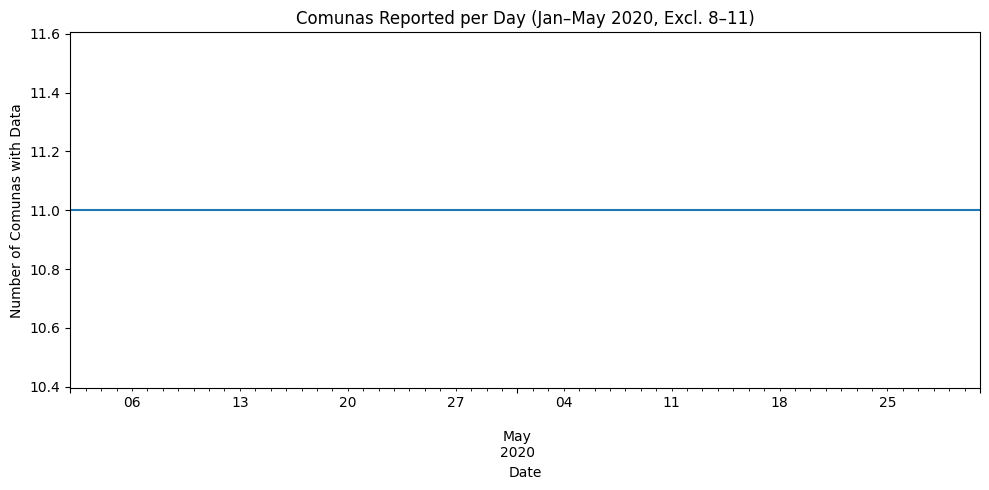

In [47]:
# Filter by date and exclude specific comunas
mask = (
    (covid_df['date'] >= '2020-04-02') &
    (covid_df['date'] <= '2020-05-31') &
    (~covid_df['comuna'].isin([8, 9, 10, 11]))
)
filtered_df = covid_df[mask]

# Count unique comunas per day
daily_comuna_counts = filtered_df.groupby('date')['comuna'].nunique()

# Plot
plt.figure(figsize=(10, 5))
daily_comuna_counts.plot()
plt.xlabel('Date')
plt.ylabel('Number of Comunas with Data')
plt.title('Comunas Reported per Day (Jan–May 2020, Excl. 8–11)')
plt.tight_layout()
plt.show()


In [57]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime and sort
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df = covid_df.sort_values(['comuna', 'date'])

# Filter out comunas 8–11
df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

# Create full MultiIndex for relevant comunas and dates
all_dates = pd.date_range('2020-01-01', '2020-05-31')
comunas = df_filtered['comuna'].unique()
multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

# Reindex and interpolate daily_cases
df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

# Identify missing comuna on April 23
existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

# Estimate total_cases using previous day's value
prev_total = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] == pd.Timestamp('2020-04-22'))
]['total_cases'].values[0]
estimated_total = prev_total + value

# Create and insert new row
new_row = {
    'date': pd.Timestamp('2020-04-23'),
    'comuna': missing_comuna,
    'daily_cases': value,
    'total_cases': estimated_total
}
covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

# --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

# Isolate comuna 6.0 from April 2 on
comuna_df = covid_df[
    (covid_df['comuna'] == 6.0) &
    (covid_df['date'] >= '2020-04-02')
].sort_values('date').copy()

# Get first known total_cases to anchor cumulative sum
anchor_total = comuna_df.iloc[0]['total_cases']

# Compute cumulative daily cases
comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

# Update total_cases in original covid_df
covid_df.loc[
    (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
    'total_cases'
] = comuna_df['adjusted_total'].values


/tmp/ipykernel_1652658/707344826.py:24: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


In [62]:
# Filter original df for that comuna and date range
window_df = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] >= '2020-04-22') &
    (covid_df['date'] <= '2020-10-29')
]

window_df[['date', 'comuna', 'daily_cases', 'total_cases']]


,date,comuna,daily_cases,total_cases
2091,2020-04-22,6.0,5.0,123.0
2092,2020-04-23,6.0,6.5,129.5
2093,2020-04-24,6.0,8.0,137.5
2094,2020-04-25,6.0,4.0,141.5
2095,2020-04-26,6.0,3.0,144.5
...,...,...,...,...
2277,2020-10-25,6.0,21.0,8277.5
2278,2020-10-26,6.0,41.0,8318.5
2279,2020-10-27,6.0,43.0,8361.5
2280,2020-10-28,6.0,61.0,8422.5


In [60]:
covid_df

,date,comuna,daily_cases,total_cases
0,2020-03-05,1.0,2.0,2.0
1,2020-03-11,1.0,1.0,3.0
2,2020-03-12,1.0,2.0,5.0
3,2020-03-13,1.0,2.0,7.0
4,2020-03-15,1.0,3.0,10.0
...,...,...,...,...
6006,2022-01-15,15.0,1.0,14910.0
6007,2022-01-16,15.0,2.0,14912.0
6008,2022-01-17,15.0,1.0,14913.0
6009,2022-01-18,15.0,1.0,14914.0


In [3]:
import pandas as pd


# List of unique comuna names
unique_comunas = sorted(covid_df['comuna'].unique())  # Sorted for readability
print("Unique Comunas:", unique_comunas)

# Count unique comunas per day
comuna_counts = covid_df.groupby('date')['comuna'].nunique()

# Find the maximum number of comunas recorded on any single day
max_comunas = comuna_counts.max()

# Find the longest stretch where this maximum number was reached
max_stretch = comuna_counts[comuna_counts == max_comunas]

# Identify the start and end of the longest continuous period
longest_start = None
longest_end = None
current_start = None
current_end = None
longest_length = 0
current_length = 0

for date in max_stretch.index:
    if current_start is None:
        current_start = date
        current_end = date
        current_length = 1
    elif (date - current_end).days == 1:  # Consecutive day
        current_end = date
        current_length += 1
    else:  # Break in continuity
        if current_length > longest_length:
            longest_start = current_start
            longest_end = current_end
            longest_length = current_length
        current_start = date
        current_end = date
        current_length = 1

# Check the last recorded stretch
if current_length > longest_length:
    longest_start = current_start
    longest_end = current_end
    longest_length = current_length

print(f"Longest stretch of {max_comunas} comunas reporting data:")
print(f"Start: {longest_start}, End: {longest_end}, Duration: {longest_length} days")


NameError: name 'covid_df' is not defined

In [36]:
import pandas as pd

# Filter data after 2020-05-04
filtered_df = covid_df[covid_df['date'] > '2020-05-04']

# Get set of all unique comunas
all_comunas = set(covid_df['comuna'].unique())

# Group by date and check when all comunas have total_cases > 10
for date, group in filtered_df.groupby('date'):
    comunas_with_cases_above_10 = set(group[group['total_cases'] > 10]['comuna'])
    
    # Check if all comunas are included
    if all_comunas.issubset(comunas_with_cases_above_10):
        print(f"First date where all comunas had total_cases > 10: {date.date()}")
        break


First date where all comunas had total_cases > 10: 2020-05-05


,date,comuna,daily_cases,total_cases
17,2020-03-05,1.0,2,2
29,2020-03-11,1.0,1,3
35,2020-03-12,1.0,2,5
42,2020-03-13,1.0,2,7
50,2020-03-15,1.0,3,10
...,...,...,...,...
5959,2022-01-15,15.0,1,14910
5963,2022-01-16,15.0,2,14912
5972,2022-01-17,15.0,1,14913
5983,2022-01-18,15.0,1,14914


In [ ]:
1

In [28]:
with open("Buenos Aires Home Patches.pkl", "rb") as file:
    home_patches = pickle.load(file)

def expand_array(short_array):
    long_array = np.zeros(6084)  # Create a zero array of the desired size

    # Assign values at the correct positions
    long_array[home_patches] = short_array
    return long_array




def compress_timeseries(long_timeseries):
    compressed = np.zeros((day_range, 78))  # Adjusted to match the original short array shape
    
    for i in range(day_range):
        compressed[i] = compress_array(long_timeseries[i])
        
    return compressed.T  # Transpose back to match original input shape

def compress_array(long_array):
    return long_array[home_patches]  # Extract values from the expanded positions


def expand_betas(short_betas,long_length):
    
    long_betas = np.zeros(long_length)
    index = 0
    for i in valid_patch_indices:
        long_betas[i] = short_betas[index]
        index += 1
    
    return long_betas



with open("BA_Patch_Population_Map_1km.pkl", "rb") as file:
    pop_dict = pickle.load(file)
    
# Assuming pop_dict is a pandas DataFrame
pop_dict = dict(zip(pop_dict['estacion'], pop_dict['population']))
pop_dict = dict(sorted(pop_dict.items()))
    
# Extract values in order
short_pop_vector = np.array(list(pop_dict.values()))

pop_vector = expand_array(short_pop_vector)
    
borough_list = np.array(range(15))+1
    
with open("ba_big station list.pkl", "rb") as file:
    station_list = pickle.load(file)
    
with open("station_comuna_dict.pkl", 'rb') as f:
    station_comuna_dict = pickle.load(f)
    
station_borough_list = list(station_comuna_dict.values())
    
with open("BA Station Comuna Proportions Dict.pkl", 'rb') as f:
    props_dict = pickle.load(f)
    
with open("BA_Covid_Data.pkl", 'rb') as f:
    covid_df = pickle.load(f)
    
    
import pandas as pd
import matplotlib.pyplot as plt

# Ensure datetime and sort
covid_df['date'] = pd.to_datetime(covid_df['date'])
covid_df = covid_df.sort_values(['comuna', 'date'])

# Filter out comunas 8–11
df_filtered = covid_df[~covid_df['comuna'].isin([8, 9, 10, 11])]

# Create full MultiIndex for relevant comunas and dates
all_dates = pd.date_range('2020-01-01', '2020-05-31')
comunas = df_filtered['comuna'].unique()
multi_index = pd.MultiIndex.from_product([comunas, all_dates], names=['comuna', 'date'])

# Reindex and interpolate daily_cases
df_full = df_filtered.set_index(['comuna', 'date']).reindex(multi_index)
df_full['daily_cases'] = df_full['daily_cases'].interpolate(limit_direction='both')

# Identify missing comuna on April 23
existing_comunas = df_filtered[df_filtered['date'] == '2020-04-23']['comuna'].unique()
interpolated_apr23 = df_full.loc[pd.IndexSlice[:, '2020-04-23'], 'daily_cases']
missing_comuna = list(set(interpolated_apr23.index.get_level_values(0)) - set(existing_comunas))[0]
value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar

# Estimate total_cases using previous day's value
prev_total = covid_df[
    (covid_df['comuna'] == missing_comuna) &
    (covid_df['date'] == pd.Timestamp('2020-04-22'))
]['total_cases'].values[0]
estimated_total = prev_total + value

# Create and insert new row
new_row = {
    'date': pd.Timestamp('2020-04-23'),
    'comuna': missing_comuna,
    'daily_cases': value,
    'total_cases': estimated_total
}
covid_df = pd.concat([covid_df, pd.DataFrame([new_row])], ignore_index=True)
covid_df = covid_df.sort_values(['comuna', 'date']).reset_index(drop=True)

# --- Recalculate total_cases from April 2 onward for comuna 6.0 ---

# Isolate comuna 6.0 from April 2 on
comuna_df = covid_df[
    (covid_df['comuna'] == 6.0) &
    (covid_df['date'] >= '2020-04-02')
].sort_values('date').copy()

# Get first known total_cases to anchor cumulative sum
anchor_total = comuna_df.iloc[0]['total_cases']

# Compute cumulative daily cases
comuna_df['cumulative_daily'] = comuna_df['daily_cases'].cumsum()
comuna_df['adjusted_total'] = anchor_total + (comuna_df['cumulative_daily'] - comuna_df.iloc[0]['cumulative_daily'])

# Update total_cases in original covid_df
covid_df.loc[
    (covid_df['comuna'] == 6.0) & (covid_df['date'] >= '2020-04-02'),
    'total_cases'
] = comuna_df['adjusted_total'].values


    
with open("ba_all_paths.pkl", 'rb') as f:
    all_paths = pickle.load(f)
    
# with open("Final Commuter Matrix Buenos Aires.pkl", "rb") as file:
    # commuter_array = pickle.load(file)
################################################################################################
################################################################################################
################################################################################################
################################################################################################
    
def get_timeseries(station_name,covid_df,props_dict):
    
    current_borough = props_dict[station_name][0]
    
    # Filter data for the given area_name "Lambeth" and within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] <= "2020-08-07") & 
        (covid_df['comuna'] == current_borough)
    ]

    # Find the earliest date where total_cases is nonzero
    # earliest_nonzero_date = filtered_df.loc[filtered_df['total_cases'] > 0, 'date'].min()
    earliest_nonzero_date = "2020-07-23"

    # Filter again using the adjusted start date
    filtered_df = filtered_df[
        (filtered_df['date'] >= earliest_nonzero_date) & 
        (filtered_df['date'] <= "2020-08-07")
    ]
    
    borough_timeseries = np.array(list(filtered_df['total_cases']))
    
    station_timeseries = props_dict[station_name][1]*borough_timeseries
    

    
    
    return station_timeseries



def get_timeseries_with_five(station_name, covid_df, props_dict):
    current_borough = props_dict[station_name][0]

    # Define the start and end dates
    end_date = "2020-04-18"
    earliest_nonzero_date = "2020-04-05"
    five_days_before = "2020-04-02"  # 5 days before the earliest nonzero date

    # Filter data for the given borough within the maximum date range
    filtered_df = covid_df[
        (covid_df['date'] >= earliest_nonzero_date) & 
        (covid_df['date'] <= end_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    borough_timeseries = np.array(filtered_df['total_cases'])
    station_timeseries = props_dict[station_name][1] * borough_timeseries

    # Get new cases in the 5 days before the earliest nonzero date
    previous_df = covid_df[
        (covid_df['date'] >= five_days_before) & 
        (covid_df['date'] < earliest_nonzero_date) & 
        (covid_df['comuna'] == current_borough)
    ]
    
    total_new_cases_prev_5_days = props_dict[station_name][1]*previous_df['daily_cases'].sum()

    return station_timeseries, total_new_cases_prev_5_days


################################################################################################
################################################################################################
################################################################################################
################################################################################################

all_station_timeseries = []
all_new_cases_prev_5_days = []
for i in range(len(station_list)):
    timeseries = get_timeseries_with_five(station_list[i],covid_df,props_dict)
    all_station_timeseries.append(timeseries[0])
    all_new_cases_prev_5_days.append(timeseries[1])
    
    
all_station_timeseries = np.array(all_station_timeseries)
day_range = all_station_timeseries[0].shape[0]
print(day_range)

def expand_timeseries(short_timeseries,timespan=day_range):
    
    transposed = short_timeseries.T
    
    long_timeseries = np.zeros((timespan,6084))
    for i in range(timespan):
        long_timeseries[i] = expand_array(transposed[i])
        
    long_timeseries = np.array(long_timeseries)
    
    return long_timeseries

working_timeseries = expand_timeseries(all_station_timeseries,day_range)
short_pop_vector = np.array(list(pop_dict.values()))
pop_vector = expand_array(short_pop_vector)
day_list = np.arange(day_range)
data = np.column_stack((day_list[:, None], working_timeseries))


current_cases = np.array(all_new_cases_prev_5_days)
cum_cases = data[0][1:]

 



# Define main control panel functions

# with open("London new Nj.pkl", "rb") as file:
    # Nj = pickle.load(file)
    

    
# Load files
with open("Sparse Buenos Aires P-Matrix.pkl", "rb") as file:
    sparse_p = pickle.load(file)

p_matrix = sparse_p.toarray()
Nj = pop_vector @ p_matrix

with open("Buenos Aires Valid Patches.pkl", 'rb') as f:
    valid_patches = pickle.load(f)
    
with open("Buenos Aires Valid Patch Indices.pkl", 'rb') as f:
    valid_patch_indices = pickle.load(f)


np.set_printoptions(suppress=True)

travel_patches = []
for i in valid_patch_indices:
    if i not in home_patches:
        travel_patches.append(i)

current_cases

14


/tmp/ipykernel_1655381/2614104353.py:90: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  value = float(interpolated_apr23.loc[missing_comuna])  # proper scalar


array([0.53309146, 3.06198276, 1.36098964, 0.84738171, 2.87982388,
       0.34494154, 3.1537043 , 1.50258624, 3.68067577, 2.53600832,
       1.62879848, 0.79005452, 1.89181386, 2.34665845, 3.49440066,
       2.29503324, 0.98256074, 0.58274214, 1.3825862 , 6.35516468,
       2.82338537, 1.11138307, 1.21614967, 1.61165043, 1.7936081 ,
       6.26534752, 1.80360422, 2.11711224, 1.53761633, 2.06430192,
       1.17870608, 0.59058172, 1.32750228, 2.30932008, 6.64022169,
       3.50414972, 1.27523841, 3.72712931, 3.27605848, 9.73465248,
       1.52214862, 3.91770601, 1.86672538, 0.69510946, 1.36670018,
       2.31210395, 1.9770448 , 1.86616643, 3.07474284, 0.56183659,
       3.98705662, 3.72163626, 2.89957563, 3.36122794, 1.14553453,
       1.12199615, 1.9188274 , 0.41549776, 1.68324814, 1.76390558,
       2.15869142, 1.38876446, 3.14210942, 3.51984935, 1.54178414,
       2.75762032, 0.97994755, 1.12889957, 1.6684458 , 1.96250828,
       2.7576425 , 0.96780152, 2.69703174, 1.04105205, 2.08008

In [64]:
import numpy as np
import pandas as pd
from scipy.stats import linregress

def find_best_fit_period(covid_df):
    """
    Finds the best 16-day period to estimate beta for an SIR model by identifying 
    the period with the most linear trend in log-transformed total cases.

    Parameters:
    covid_df (pd.DataFrame): DataFrame with 'date', 'comuna', 'total_cases'.

    Returns:
    tuple: (start_date, end_date, best_r2)
    """
    # Convert date column to datetime format
    covid_df["date"] = pd.to_datetime(covid_df["date"])

    # Filter data from May 5, 2020, onwards
    covid_df = covid_df[covid_df["date"] >= "2020-05-05"]

    # Aggregate total cases across all comunas for each date
    covid_timeseries = covid_df.groupby("date")["total_cases"].sum().reset_index()

    # Log-transform total cases (replace 0 with NaN to avoid log issues)
    covid_timeseries["log_cases"] = np.log(covid_timeseries["total_cases"].replace(0, np.nan))

    best_r2 = -np.inf
    best_period = (covid_timeseries.iloc[0]["date"], covid_timeseries.iloc[15]["date"], -1)  # Default to first 16 days

    # Loop through all possible 16-day windows
    for i in range(len(covid_timeseries) - 15):
        subset = covid_timeseries.iloc[i : i + 16]

        # Drop NaNs from log-transformed total cases
        subset = subset.dropna(subset=["log_cases"])

        if len(subset) < 10:  # Ensure enough points for meaningful regression
            continue

        # Perform linear regression on log-transformed total cases
        x = np.arange(len(subset))
        y = subset["log_cases"].values
        slope, intercept, r_value, p_value, std_err = linregress(x, y)

        # Select period with the highest R-squared (strongest exponential trend)
        if r_value**2 > best_r2:
            best_r2 = r_value**2
            best_period = (subset.iloc[0]["date"], subset.iloc[-1]["date"], best_r2)

    return best_period  # Always returns the best available 16-day period

# Example usage:
best_start, best_end, best_r2 = find_best_fit_period(covid_df)
print(f"Best 16-day period: {best_start} to {best_end} (R² = {best_r2:.3f})")


Best 16-day period: 2020-07-23 00:00:00 to 2020-08-07 00:00:00 (R² = 0.999)


In [21]:
all_station_timeseries

array([[12.09148368, 13.73922093, 15.16887532, ..., 37.75256828,
        41.26612567, 44.85237734],
       [45.92974146, 47.81403854, 49.46279849, ..., 70.6611407 ,
        73.01651206, 75.84295769],
       [34.32718303, 35.83939374, 39.31747836, ..., 59.88354397,
        62.75674431, 67.14215536],
       ...,
       [13.1583793 , 14.95150514, 16.50730549, ..., 41.08367725,
        44.9072544 , 48.80994004],
       [31.58819651, 33.13087587, 34.37971155, ..., 71.55093813,
        79.04395219, 86.83080993],
       [37.88324052, 38.87042594, 40.2278059 , ..., 56.14617081,
        58.73753254, 62.93307058]])

In [5]:
def initialize_concise_betas(home_patches,big_beta):
    simple_beta = expand_betas(big_beta,6084)[home_patches]
    travel_patch_beta = 0.2
    output_beta = np.zeros(252)
    for i in range(78):
        output_beta[i] = simple_beta[i]
    output_beta[-1] = travel_patch_beta
    return output_beta


In [6]:
def isolate_travel_betas(home_patches,travel_patches,travel_betas,concise_betas):
    home_betas = np.zeros(78)
    for i in range(78):
        home_betas[i] = concise_betas[i]
    
    
    
    return long_beta

In [44]:
lengths = []

for i in all_station_timeseries:
    lengths.append(i.shape[0])
    
print(np.sort(lengths))

[16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16 16
 16 16 16 16 16 16]


In [6]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    beta = expand_concise_betas(home_patches,travel_patches,beta)
    # beta = expand_detailed_beta(beta)
    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps-1,num=timesteps)
    
    
    
    def sir(y,timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        # dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    

In [47]:
starting_beta = np.ones(79)*0.4
best_beta_yet_0 = starting_beta.copy()

In [73]:
best_beta_yet_0.shape

(246,)

In [67]:
np.array(new_Beta_0).shape

(246,)

In [4]:
len(valid_patch_indices)

246

In [5]:
def make_detailed_beta(short_beta):
    new_beta_0 = np.zeros(246)

    for i in range(78):
        new_beta_0[i] = short_beta[i]
    for i in range(246-78):
        new_beta_0[i+78] = short_beta[-1]
    return np.array(new_beta_0)

def expand_detailed_beta(detailed_beta):
    big_beta = np.zeros(6084)
    home_betas = detailed_beta[:78]
    travel_betas = detailed_beta[78:]
    big_beta[home_patches] = home_betas
    big_beta[travel_patches] = travel_betas
    
    return big_beta

In [6]:
with open("Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
best_beta_yet_0  = make_detailed_beta(best_beta_yet_0)
best_beta_yet_0

array([0.07321959, 0.13372753, 0.16605142, 0.05004562, 0.1060049 ,
       0.05340215, 0.28226343, 0.17698496, 0.19497549, 0.09876435,
       0.16983637, 0.05003496, 0.20461101, 0.091289  , 0.22244226,
       0.0902197 , 0.13382523, 0.09989917, 0.0579574 , 0.32177178,
       0.33907596, 0.19216373, 0.08060423, 0.11103881, 0.14097025,
       0.26829374, 0.19758169, 0.07379834, 0.11118068, 0.22318556,
       0.05227845, 0.11627226, 0.16573149, 0.11121615, 0.4672804 ,
       0.17907467, 0.19613337, 0.14886172, 0.19849987, 0.25171028,
       0.06999643, 0.19469762, 0.17436022, 0.10301786, 0.20290937,
       0.09705344, 0.10650628, 0.21567801, 0.10967645, 0.08477085,
       0.1424984 , 0.1262912 , 0.08909183, 0.21571635, 0.05539482,
       0.06142165, 0.10880993, 0.07619107, 0.25080726, 0.33828357,
       0.08659285, 0.097655  , 0.17318633, 0.21482838, 0.35594207,
       0.17014852, 0.13580932, 0.17150788, 0.44875994, 0.32631558,
       0.93002172, 0.18711906, 0.23950656, 0.50973063, 0.20366

In [12]:
expand_detailed_beta(best_beta_yet_0).shape

(6084,)

In [9]:
with open("BA_final_best_beta_with_R.pkl", "rb") as file:
    small_beta = pickle.load(file)

best_beta_yet_0 = make_detailed_beta(expand_concise_betas(home_patches,travel_patches,small_beta))

In [77]:
test = expand_detailed_beta(best_beta_yet_0)

In [11]:
small_beta.shape

(79,)

In [68]:
cum_cases.shape

(6084,)

In [67]:
current_cases.shape

(78,)

In [29]:
def expand_concise_betas(home_patches,travel_patches,concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta

import numpy as np
import pickle
from scipy.optimize import minimize
from scipy.sparse import csr_matrix

# Global variable to track the best beta and error
best_beta = None
best_error = float('inf')
with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
# best_beta_yet_0 = expand_concise_betas(home_patches,travel_patches,best_beta_yet_0)
print(best_beta_yet_0.shape)

def error_function(beta, data, pop_dict):
    global best_beta, best_error
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(6084)
    pop_vector[np.arange(78) * (78 + 1)] = short_pop_vector

    I0 = np.zeros(6084)
    
    
    
    
    I0[home_patches] = current_cases
    
    
    
    
    S0 = pop_vector - I0
    I_total_0 = cum_cases
    
    gamma = 1/5

    params = [S0, I0, I_total_0, beta, gamma, int(data[-1, 0])]
    y = run_model_London(params)[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data[:, 1:])  

    # normalizer = compress_array(pop_vector)[:, np.newaxis]  # Ensure correct shape
    normalizer = short_pop_vector

    # Apply normalization to both real data and model output
    real_data = raw_real_data / normalizer[:, np.newaxis]
    model_data = I_sum_model / normalizer[:, np.newaxis]
    # real_data = raw_real_data
    # model_data = I_sum_model

    # Ensure shapes match before computing error
    if real_data.shape != model_data.shape:
        raise ValueError(f"Shape mismatch: real_data {real_data.shape} vs model_data {model_data.shape}")

    # Exclude index 143 from error calculation
    error_matrix = (model_data - real_data) ** 2
    # error_matrix[143] = 0  # Exclude index 143

    squared_error = np.sum(error_matrix)
    # squared_error = np.sum((model_data - real_data) ** 2)
    # Regularization with Elastic Net
    l1_penalty = 1e-4 * (1 + np.std(beta))
    l2_penalty = 1e-4 * (1 + np.mean(beta)**2)

    # l1_penalty = 1e-4 * np.sum(np.abs(beta - np.mean(beta)))  # L1 penalty
    # l2_penalty = 1e-4 * np.sum((beta - np.mean(beta)) ** 2)  # L2 penalty
    total_error = squared_error + l1_penalty + l2_penalty
    
    # Save best beta
    if total_error < best_error:
        best_error = total_error
        best_beta = beta.copy()
        
        with open("Normed Distributed Updated Formalized Buenos Aires Beta.pkl", "wb") as f:
            pickle.dump(best_beta, f)
        print(f"New best beta found. Error: {best_error:.12f}")

    return total_error




# Optimized fitting function
def sir_simulation_fit_class(full_timeseries, pop_dict):
    working_timeseries = expand_timeseries(full_timeseries,day_range)
    
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))

    
    # initial_guess = best_beta_yet_0.copy()
    initial_guess = np.clip(best_beta_yet_0.copy(), 0.1, 0.6)
    # initial_guess = np.ones(79)*0.3

    beta_bounds = [(0.1, 0.6)] * 79

    result = minimize(error_function, initial_guess, args=(data, pop_dict), method='Powell', bounds=beta_bounds)

    print('Estimated beta:', result.x)
    print('Final minimized error:', result.fun)

    # Save final optimized beta
    with open("Normed Distributed Updated Final Formalized Buenos Aires Beta.pkl", "wb") as f:
        pickle.dump(result.x, f)

    return result.x

# Run fitting
sir_simulation_fit_class(all_station_timeseries, pop_dict)


(79,)
New best beta found. Error: 0.000387214376
New best beta found. Error: 0.000387062753
New best beta found. Error: 0.000387058695
New best beta found. Error: 0.000387058559
New best beta found. Error: 0.000387058558
New best beta found. Error: 0.000386761287
New best beta found. Error: 0.000386220888
New best beta found. Error: 0.000385763998
New best beta found. Error: 0.000385553402
New best beta found. Error: 0.000385446036
New best beta found. Error: 0.000385387466
New best beta found. Error: 0.000385354047
New best beta found. Error: 0.000385334410
New best beta found. Error: 0.000385322653
New best beta found. Error: 0.000385315530
New best beta found. Error: 0.000385311181
New best beta found. Error: 0.000385308514
New best beta found. Error: 0.000385306873
New best beta found. Error: 0.000385305862
New best beta found. Error: 0.000385305239
New best beta found. Error: 0.000385304854
New best beta found. Error: 0.000385304616
New best beta found. Error: 0.000384094084
New b

New best beta found. Error: 0.000367563935
New best beta found. Error: 0.000367243371
New best beta found. Error: 0.000367023397
New best beta found. Error: 0.000367010839
New best beta found. Error: 0.000367003726
New best beta found. Error: 0.000366999572
New best beta found. Error: 0.000366997095
New best beta found. Error: 0.000366995598
New best beta found. Error: 0.000366994686
New best beta found. Error: 0.000366994127
New best beta found. Error: 0.000366993784
New best beta found. Error: 0.000366993572
New best beta found. Error: 0.000366993442
New best beta found. Error: 0.000366993361
New best beta found. Error: 0.000366986000
New best beta found. Error: 0.000366982646
New best beta found. Error: 0.000366982563
New best beta found. Error: 0.000366982561
New best beta found. Error: 0.000366838435
New best beta found. Error: 0.000366769743
New best beta found. Error: 0.000366768535
New best beta found. Error: 0.000366768510
New best beta found. Error: 0.000366768510
New best be

New best beta found. Error: 0.000298583193
New best beta found. Error: 0.000298582713
New best beta found. Error: 0.000298582702
New best beta found. Error: 0.000298582702
New best beta found. Error: 0.000298552084
New best beta found. Error: 0.000298479107
New best beta found. Error: 0.000298470189
New best beta found. Error: 0.000298465271
New best beta found. Error: 0.000298465270
New best beta found. Error: 0.000298459101
New best beta found. Error: 0.000298459100
New best beta found. Error: 0.000298459100
New best beta found. Error: 0.000298442351
New best beta found. Error: 0.000298399302
New best beta found. Error: 0.000298399248
New best beta found. Error: 0.000298399248
New best beta found. Error: 0.000298275114
New best beta found. Error: 0.000298248991
New best beta found. Error: 0.000298117283
New best beta found. Error: 0.000298102179
New best beta found. Error: 0.000298099164
New best beta found. Error: 0.000298098781
New best beta found. Error: 0.000298098771
New best be

New best beta found. Error: 0.000239277819
New best beta found. Error: 0.000239277817
New best beta found. Error: 0.000238336656
New best beta found. Error: 0.000238317142
New best beta found. Error: 0.000238313510
New best beta found. Error: 0.000238313396
New best beta found. Error: 0.000238313391
New best beta found. Error: 0.000238313391
New best beta found. Error: 0.000237955827
New best beta found. Error: 0.000237955428
New best beta found. Error: 0.000237955239
New best beta found. Error: 0.000237955239
New best beta found. Error: 0.000236430185
New best beta found. Error: 0.000236416314
New best beta found. Error: 0.000236405230
New best beta found. Error: 0.000236405227
New best beta found. Error: 0.000236405227
New best beta found. Error: 0.000235958850
New best beta found. Error: 0.000235947416
New best beta found. Error: 0.000235938647
New best beta found. Error: 0.000235938573
New best beta found. Error: 0.000235938563
New best beta found. Error: 0.000235938563
New best be

New best beta found. Error: 0.000216900055
New best beta found. Error: 0.000216884650
New best beta found. Error: 0.000216884646
New best beta found. Error: 0.000216884645
New best beta found. Error: 0.000216872281
New best beta found. Error: 0.000216817094
New best beta found. Error: 0.000216817091
New best beta found. Error: 0.000216817091
New best beta found. Error: 0.000216659328
New best beta found. Error: 0.000216654939
New best beta found. Error: 0.000216654937
New best beta found. Error: 0.000216654934
New best beta found. Error: 0.000216564502
New best beta found. Error: 0.000216564346
New best beta found. Error: 0.000216564286
New best beta found. Error: 0.000216564286
New best beta found. Error: 0.000216547312
New best beta found. Error: 0.000216543447
New best beta found. Error: 0.000216543173
New best beta found. Error: 0.000216543161
New best beta found. Error: 0.000216543161
New best beta found. Error: 0.000216285207
New best beta found. Error: 0.000216285113
New best be

New best beta found. Error: 0.000213156414
New best beta found. Error: 0.000213156408
New best beta found. Error: 0.000213156408
New best beta found. Error: 0.000213114295
New best beta found. Error: 0.000213114148
New best beta found. Error: 0.000213114097
New best beta found. Error: 0.000213114097
New best beta found. Error: 0.000213092353
New best beta found. Error: 0.000213054769
New best beta found. Error: 0.000213041852
New best beta found. Error: 0.000213039138
New best beta found. Error: 0.000213039137
New best beta found. Error: 0.000213039136
New best beta found. Error: 0.000213032611
New best beta found. Error: 0.000213024379
New best beta found. Error: 0.000213018605
New best beta found. Error: 0.000213018575
New best beta found. Error: 0.000213018571
New best beta found. Error: 0.000212998958
New best beta found. Error: 0.000212998881
New best beta found. Error: 0.000212998879
New best beta found. Error: 0.000212981068
New best beta found. Error: 0.000212981067
New best be

New best beta found. Error: 0.000212667660
New best beta found. Error: 0.000212667535
New best beta found. Error: 0.000212667529
New best beta found. Error: 0.000212661042
New best beta found. Error: 0.000212659542
New best beta found. Error: 0.000212659373
New best beta found. Error: 0.000212659369
New best beta found. Error: 0.000212655546
New best beta found. Error: 0.000212655329
New best beta found. Error: 0.000212655322
New best beta found. Error: 0.000212636390
New best beta found. Error: 0.000212635655
New best beta found. Error: 0.000212635529
New best beta found. Error: 0.000212635527
New best beta found. Error: 0.000212628763
New best beta found. Error: 0.000212628753
New best beta found. Error: 0.000212623105
New best beta found. Error: 0.000212623039
New best beta found. Error: 0.000212623039
New best beta found. Error: 0.000212620699
New best beta found. Error: 0.000212620657
New best beta found. Error: 0.000212620657
New best beta found. Error: 0.000212619977
New best be

New best beta found. Error: 0.000212575181
New best beta found. Error: 0.000212575177
New best beta found. Error: 0.000212575176
New best beta found. Error: 0.000212575086
New best beta found. Error: 0.000212574865
New best beta found. Error: 0.000212574862
New best beta found. Error: 0.000212574860
New best beta found. Error: 0.000212574859
New best beta found. Error: 0.000212574858
New best beta found. Error: 0.000212574854
New best beta found. Error: 0.000212574852
New best beta found. Error: 0.000212574852
New best beta found. Error: 0.000212574829
New best beta found. Error: 0.000212574824
New best beta found. Error: 0.000212574824
New best beta found. Error: 0.000212574810
New best beta found. Error: 0.000212574809
New best beta found. Error: 0.000212574806
New best beta found. Error: 0.000212574806
New best beta found. Error: 0.000212574800
New best beta found. Error: 0.000212574797
New best beta found. Error: 0.000212574795
New best beta found. Error: 0.000212574789
New best be

New best beta found. Error: 0.000212569637
New best beta found. Error: 0.000212569634
New best beta found. Error: 0.000212569631
New best beta found. Error: 0.000212569627
New best beta found. Error: 0.000212569627
New best beta found. Error: 0.000212569627
New best beta found. Error: 0.000212569616
New best beta found. Error: 0.000212569611
New best beta found. Error: 0.000212569611
New best beta found. Error: 0.000212569590
New best beta found. Error: 0.000212569589
New best beta found. Error: 0.000212569585
New best beta found. Error: 0.000212569570
New best beta found. Error: 0.000212569570
New best beta found. Error: 0.000212569559
New best beta found. Error: 0.000212569550
New best beta found. Error: 0.000212569532
New best beta found. Error: 0.000212569531
New best beta found. Error: 0.000212569529
New best beta found. Error: 0.000212569523
New best beta found. Error: 0.000212569520
New best beta found. Error: 0.000212569515
New best beta found. Error: 0.000212569505
New best be

array([0.25705973, 0.2301389 , 0.25943237, 0.22131062, 0.23166096,
       0.25372746, 0.271589  , 0.25524658, 0.23580556, 0.25056538,
       0.2595787 , 0.21291617, 0.26757519, 0.22113057, 0.34394543,
       0.23350709, 0.25415002, 0.25763899, 0.21857989, 0.31598657,
       0.26055836, 0.2619295 , 0.21542368, 0.29397412, 0.29495233,
       0.35351214, 0.26989742, 0.22604409, 0.29011699, 0.26638046,
       0.21506237, 0.25400442, 0.25477223, 0.22625392, 0.35008715,
       0.34072141, 0.25585179, 0.30624626, 0.23039151, 0.43259901,
       0.22178068, 0.31490278, 0.26429776, 0.25344381, 0.25708841,
       0.23297333, 0.29338308, 0.27214239, 0.23111103, 0.25239737,
       0.25045966, 0.25038612, 0.25147649, 0.36043954, 0.22494337,
       0.21834785, 0.2263333 , 0.2515276 , 0.26703229, 0.25631701,
       0.25022291, 0.21450583, 0.22927982, 0.23058774, 0.25833987,
       0.23290225, 0.25449208, 0.2546194 , 0.26541867, 0.25551205,
       0.26414293, 0.25018995, 0.25045419, 0.25525197, 0.29612

In [65]:
with open("Updated Final Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta = pickle.load(file)
    
best_beta

array([0.24904536, 0.34050878, 0.51713763, 0.17854802, 0.30752617,
       0.20741163, 0.59647728, 0.61515903, 0.53055975, 0.31693093,
       0.50949073, 0.13342264, 0.48711488, 0.29159956, 0.48577076,
       0.25974415, 0.54790042, 0.37132014, 0.19073234, 0.89994776,
       0.89994776, 0.61984356, 0.32055926, 0.32034505, 0.40088081,
       0.66614318, 0.47975639, 0.21310702, 0.35035401, 0.59668315,
       0.18231468, 0.53735546, 0.60682657, 0.37641461, 0.80710641,
       0.39494415, 0.70791735, 0.43514182, 0.48535092, 0.70204455,
       0.25176269, 0.59561837, 0.49402377, 0.464451  , 0.70766863,
       0.2953932 , 0.29132122, 0.52873269, 0.31994268, 0.41243884,
       0.40369804, 0.36272831, 0.26710894, 0.48670881, 0.21980479,
       0.24852185, 0.40401061, 0.44176378, 0.63209621, 0.89994776,
       0.29173926, 0.36869147, 0.45350005, 0.51892666, 0.89994776,
       0.52424544, 0.5480855 , 0.69593385, 0.89994776, 0.89994776,
       0.89994776, 0.67075662, 0.78316519, 0.89994776, 0.51681

In [40]:
all_new_cases_prev_5_days

array([694, 279, 294, 552, 390, 694, 551, 694, 390, 391, 294, 552, 551,
       552, 865, 390, 694, 694, 552, 361, 694, 294, 552, 352, 352, 306,
       551, 552, 352, 294, 552, 694, 694, 552, 865, 865, 694, 361, 279,
       306, 552, 361, 294, 694, 694, 390, 352, 551, 390, 694, 391, 391,
       391, 865, 552, 552, 552, 694, 551, 694, 391, 552, 279, 279, 694,
       390, 694, 694, 551, 694, 551, 294, 391, 694, 352, 694, 551, 552])

In [20]:
import numpy as np
import pickle
from scipy.optimize import minimize
from scipy.sparse import csr_matrix

# Global variable to track the best beta and error
best_beta = None
best_error = float('inf')

with open("Final Formalized Buenos Aires Beta.pkl", "rb") as file:
    best_beta_yet_0 = pickle.load(file)
    
best_beta_yet_0 = np.ones(79)*0.4

def expand_concise_betas(home_patches, travel_patches, concise_beta):
    long_beta = np.zeros(6084)
    for i in range(78):
        long_beta[home_patches[i]] = concise_beta[i]
    long_beta[travel_patches] = concise_beta[-1]
    
    return long_beta

def error_function(beta, data, pop_dict):
    global best_beta, best_error
    
    print("\n=== Debug: Entering error_function ===")
    print(f"Current beta: {beta[:10]} ... (showing first 10 values)")
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(6084)
    pop_vector[np.arange(78) * (78 + 1)] = short_pop_vector

    I0 = data[0, 1:]
    S0 = pop_vector - I0
    I_total_0 = I0.copy()

    gamma = 1/5
    params = [S0, I0, I_total_0, beta, gamma, int(data[-1, 0])]
    
    print(f"Initial infected (I0): {I0[:10]} ... (showing first 10 values)")
    print(f"Total simulation days: {params[-1]}")

    # Run model
    y = run_model_London(params)[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data[:, 1:])  

    normalizer = compress_array(pop_vector)[:, np.newaxis]  # Ensure correct shape

    # Apply normalization
    real_data = raw_real_data / normalizer
    model_data = I_sum_model / normalizer

    # Check shape consistency
    if real_data.shape != model_data.shape:
        raise ValueError(f"Shape mismatch: real_data {real_data.shape} vs model_data {model_data.shape}")

    print(f"Model output shape: {model_data.shape}, Real data shape: {real_data.shape}")
    
    # Error computation
    error_matrix = (model_data - real_data) ** 2
    squared_error = np.sum(error_matrix)
    
    reg_strength = 1e-4  # Increase from 1e-4 to 1e-2
    l1_ratio = 0.1  # 10% L1, 90% L2

    # Elastic Net regularization: Combination of L1 and L2
    reg_term = reg_strength * ((1 - l1_ratio) * np.sum((beta - np.mean(beta)) ** 2) + 
                               l1_ratio * np.sum(np.abs(beta - np.mean(beta))))

    total_error = squared_error + reg_term
    
    print(f"Squared error: {squared_error:.6f}, Regularization: {reg_term:.6f}, Total error: {total_error:.6f}")

    # Save best beta
    if total_error < best_error:
        best_error = total_error
        best_beta = beta.copy()
        
        with open("Formalized Buenos Aires Beta.pkl", "wb") as f:
            pickle.dump(best_beta, f)
        print(f"New best beta found! Error: {best_error:.6f}")

    print("=== Debug: Exiting error_function ===\n")
    return total_error

# Optimized fitting function
def sir_simulation_fit_class(full_timeseries, pop_dict):
    print("\n=== Debug: Entering sir_simulation_fit_class ===")
    
    working_timeseries = expand_timeseries(day_range,full_timeseries)
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))

    print(f"Data shape: {data.shape}, First row: {data[0]}")

    initial_guess = best_beta_yet_0.copy()
    beta_bounds = [(0.05, 0.95)] * 79

    print("Starting optimization...")
    result = minimize(error_function, initial_guess, args=(data, pop_dict), 
                  method='Powell', bounds=beta_bounds, options={'disp': True})

    print("\n=== Debug: Optimization Completed ===")
    print('Estimated beta:', result.x[:10], "... (showing first 10 values)")
    print('Final minimized error:', result.fun)

    # Save final optimized beta
    with open("Final Formalized Buenos Aires Beta.pkl", "wb") as f:
        pickle.dump(result.x, f)

    return result.x

# Run fitting
sir_simulation_fit_class(all_station_timeseries, pop_dict)



=== Debug: Entering sir_simulation_fit_class ===
Data shape: (16, 6085), First row: [ 0.         12.09148368  0.         ...  0.          0.
 37.88324052]
Starting optimization...

=== Debug: Entering error_function ===
Current beta: [0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 1.038411, Regularization: 0.000000, Total error: 1.038411
New best beta found! Error: 1.038411
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.39376941 0.4        0.4        0.4        0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.956902, Regularization: 0.000018, Total error: 0.956919
New best beta found! Error: 0.956919
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595 0.4       0.4       0.4       0.4       0.4       0.4
 0.4       0.4       0.4      ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.956896, Regularization: 0.000018, Total error: 0.956914
New best beta found! Error: 0.956914
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.39376941 0.4        0.4        0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [1

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.914511, Regularization: 0.000035, Total error: 0.914547
New best beta found! Error: 0.914547
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.4        0.4        0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.914510, Regularization: 0.000035, Total error: 0.914545
New best beta found! Error: 0.914545
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.39376941 0.4        0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.879605, Regularization: 0.000052, Total error: 0.879657
New best beta found! Error: 0.879657
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05141544 0.4        0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.879566, Regularization: 0.000052, Total error: 0.879617
New best beta found! Error: 0.879617
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05087479 0.4        0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.858833, Regularization: 0.000063, Total error: 0.858896
New best beta found! Error: 0.858896
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.09805566 0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.857812, Regularization: 0.000065, Total error: 0.857877
New best beta found! Error: 0.857877
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.07970003 0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.856387, Regularization: 0.000068, Total error: 0.856456
New best beta found! Error: 0.856456
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.4        0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.856386, Regularization: 0.000068, Total error: 0.856455
New best beta found! Error: 0.856455
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.39376941 0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.813188, Regularization: 0.000084, Total error: 0.813272
New best beta found! Error: 0.813272
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05146041 0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.813135, Regularization: 0.000084, Total error: 0.813219
New best beta found! Error: 0.813219
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05090259 0.4
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.775826, Regularization: 0.000096, Total error: 0.775922
New best beta found! Error: 0.775922
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.08346862
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.774358, Regularization: 0.000097, Total error: 0.774455
New best beta found! Error: 0.774455
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.07068474
 0.4        0.4        0.4        0.4       ] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.772161, Regularization: 0.000100, Total error: 0.772261
New best beta found! Error: 0.772261
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.39376941 0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.770425, Regularization: 0.000100, Total error: 0.770525
New best beta found! Error: 0.770525
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.60623059 0.4        0.4        0.4       ] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.732431, Regularization: 0.000115, Total error: 0.732546
New best beta found! Error: 0.732546
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.05106762 0.4        0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.732403, Regularization: 0.000115, Total error: 0.732518
New best beta found! Error: 0.732518
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.05065982 0.4        0.4        0.4       ] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.709832, Regularization: 0.000126, Total error: 0.709958
New best beta found! Error: 0.709958
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.08099767 0.4        0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.709246, Regularization: 0.000127, Total error: 0.709373
New best beta found! Error: 0.709373
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.06915761 0.4        0.4       ] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.708385, Regularization: 0.000130, Total error: 0.708515
New best beta found! Error: 0.708515
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.39376941 0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.706737, Regularization: 0.000130, Total error: 0.706866
New best beta found! Error: 0.706866
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.60623059 0.4       ] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.675794, Regularization: 0.000144, Total error: 0.675937
New best beta found! Error: 0.675937
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05040686 0.4       ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.675787, Regularization: 0.000144, Total error: 0.675931
New best beta found! Error: 0.675931
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05025145 0.4       ] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.644071, Regularization: 0.000157, Total error: 0.644228
New best beta found! Error: 0.644228
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05096026] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.644047, Regularization: 0.000157, Total error: 0.644205
New best beta found! Error: 0.644205
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05059347] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.615459, Regularization: 0.000170, Total error: 0.615629
New best beta found! Error: 0.615629
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.615370, Regularization: 0.000170, Total error: 0.615541
New best beta found! Error: 0.615541
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.590650, Regularization: 0.000182, Total error: 0.590832
New best beta found! Error: 0.590832
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.590363, Regularization: 0.000183, Total error: 0.590545
New best beta found! Error: 0.590545
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.566737, Regularization: 0.000188, Total error: 0.566926
New best beta found! Error: 0.566926
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.564299, Regularization: 0.000191, Total error: 0.564489
New best beta found! Error: 0.564489
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.616469, Regularization: 0.000202, Total error: 0.616671
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.546492, Regularization: 0.000197, Total error: 0.546689
New best beta found! Error: 0.546689
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.535333, Regularization: 0.000208, Total error: 0.535541
New best beta found! Error: 0.535541
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.535332, Regularization: 0.000208, Total error: 0.535539
New best beta found! Error: 0.535539
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.510465, Regularization: 0.000219, Total error: 0.510684
New best beta found! Error: 0.510684
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.510461, Regularization: 0.000219, Total error: 0.510680
New best beta found! Error: 0.510680
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.488102, Regularization: 0.000230, Total error: 0.488332
New best beta found! Error: 0.488332
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.488085, Regularization: 0.000230, Total error: 0.488315
New best beta found! Error: 0.488315
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.473030, Regularization: 0.000240, Total error: 0.473270
New best beta found! Error: 0.473270
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.472985, Regularization: 0.000240, Total error: 0.473225
New best beta found! Error: 0.473225
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.446287, Regularization: 0.000249, Total error: 0.446536
New best beta found! Error: 0.446536
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.445870, Regularization: 0.000250, Total error: 0.446119
New best beta found! Error: 0.446119
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.428803, Regularization: 0.000256, Total error: 0.429059
New best beta found! Error: 0.429059
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.428033, Regularization: 0.000257, Total error: 0.428290
New best beta found! Error: 0.428290
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.411380, Regularization: 0.000260, Total error: 0.411640
New best beta found! Error: 0.411640
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.404234, Regularization: 0.000263, Total error: 0.404497
New best beta found! Error: 0.404497
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.430648, Regularization: 0.000277, Total error: 0.430926
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.383981, Regularization: 0.000269, Total error: 0.384250
New best beta found! Error: 0.384250
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.367900, Regularization: 0.000278, Total error: 0.368178
New best beta found! Error: 0.368178
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.367327, Regularization: 0.000278, Total error: 0.367605
New best beta found! Error: 0.367605
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.356106, Regularization: 0.000286, Total error: 0.356392
New best beta found! Error: 0.356392
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.356105, Regularization: 0.000286, Total error: 0.356391
New best beta found! Error: 0.356391
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.345028, Regularization: 0.000293, Total error: 0.345321
New best beta found! Error: 0.345321
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.344994, Regularization: 0.000294, Total error: 0.345287
New best beta found! Error: 0.345287
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.330308, Regularization: 0.000299, Total error: 0.330608
New best beta found! Error: 0.330608
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.330107, Regularization: 0.000300, Total error: 0.330407
New best beta found! Error: 0.330407
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.317546, Regularization: 0.000302, Total error: 0.317848
New best beta found! Error: 0.317848
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.316389, Regularization: 0.000304, Total error: 0.316693
New best beta found! Error: 0.316693
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.468533, Regularization: 0.000317, Total error: 0.468851
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.294147, Regularization: 0.000307, Total error: 0.294454
New best beta found! Error: 0.294454
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.286453, Regularization: 0.000314, Total error: 0.286767
New best beta found! Error: 0.286767
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.286452, Regularization: 0.000314, Total error: 0.286766
New best beta found! Error: 0.286766
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.273602, Regularization: 0.000320, Total error: 0.273922
New best beta found! Error: 0.273922
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.273600, Regularization: 0.000320, Total error: 0.273920
New best beta found! Error: 0.273920
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.262636, Regularization: 0.000326, Total error: 0.262962
New best beta found! Error: 0.262962
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.262629, Regularization: 0.000326, Total error: 0.262955
New best beta found! Error: 0.262955
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.249929, Regularization: 0.000330, Total error: 0.250260
New best beta found! Error: 0.250260
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.249889, Regularization: 0.000331, Total error: 0.250219
New best beta found! Error: 0.250219
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.237094, Regularization: 0.000334, Total error: 0.237428
New best beta found! Error: 0.237428
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.237004, Regularization: 0.000335, Total error: 0.237339
New best beta found! Error: 0.237339
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.228470, Regularization: 0.000335, Total error: 0.228805
New best beta found! Error: 0.228805
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.227821, Regularization: 0.000337, Total error: 0.228157
New best beta found! Error: 0.228157
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.242921, Regularization: 0.000350, Total error: 0.243271
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.222680, Regularization: 0.000337, Total error: 0.223017
New best beta found! Error: 0.223017
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.219647, Regularization: 0.000343, Total error: 0.219990
New best beta found! Error: 0.219990
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.219646, Regularization: 0.000343, Total error: 0.219989
New best beta found! Error: 0.219989
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.212630, Regularization: 0.000346, Total error: 0.212976
New best beta found! Error: 0.212976
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.212629, Regularization: 0.000346, Total error: 0.212976
New best beta found! Error: 0.212976
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.204116, Regularization: 0.000349, Total error: 0.204465
New best beta found! Error: 0.204465
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.204112, Regularization: 0.000349, Total error: 0.204461
New best beta found! Error: 0.204461
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.190427, Regularization: 0.000351, Total error: 0.190778
New best beta found! Error: 0.190778
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.190410, Regularization: 0.000351, Total error: 0.190761
New best beta found! Error: 0.190761
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.184084, Regularization: 0.000348, Total error: 0.184433
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.181501, Regularization: 0.000349, Total error: 0.181849
New best beta found! Error: 0.181849
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.180010, Regularization: 0.000353, Total error: 0.180363
New best beta found! Error: 0.180363
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.179748, Regularization: 0.000353, Total error: 0.180101
New best beta found! Error: 0.180101
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.172810, Regularization: 0.000354, Total error: 0.173165
New best beta found! Error: 0.173165
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.172809, Regularization: 0.000354, Total error: 0.173164
New best beta found! Error: 0.173164
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.160338, Regularization: 0.000355, Total error: 0.160694
New best beta found! Error: 0.160694
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.160334, Regularization: 0.000355, Total error: 0.160689
New best beta found! Error: 0.160689
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.149549, Regularization: 0.000356, Total error: 0.149904
New best beta found! Error: 0.149904
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.149541, Regularization: 0.000356, Total error: 0.149897
New best beta found! Error: 0.149897
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.135197, Regularization: 0.000355, Total error: 0.135552
New best beta found! Error: 0.135552
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.135086, Regularization: 0.000355, Total error: 0.135442
New best beta found! Error: 0.135442
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.129842, Regularization: 0.000354, Total error: 0.130196
New best beta found! Error: 0.130196
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.130041, Regularization: 0.000353, Total error: 0.130394
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.123932, Regularization: 0.000351, Total error: 0.124283
New best beta found! Error: 0.124283
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.123587, Regularization: 0.000351, Total error: 0.123938
New best beta found! Error: 0.123938
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.120577, Regularization: 0.000354, Total error: 0.120932
New best beta found! Error: 0.120932
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.120220, Regularization: 0.000354, Total error: 0.120574
New best beta found! Error: 0.120574
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.113861, Regularization: 0.000353, Total error: 0.114214
New best beta found! Error: 0.114214
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.113860, Regularization: 0.000353, Total error: 0.114214
New best beta found! Error: 0.114214
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.110307, Regularization: 0.000351, Total error: 0.110658
New best beta found! Error: 0.110658
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.110305, Regularization: 0.000351, Total error: 0.110656
New best beta found! Error: 0.110656
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.105323, Regularization: 0.000349, Total error: 0.105671
New best beta found! Error: 0.105671
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.105310, Regularization: 0.000349, Total error: 0.105659
New best beta found! Error: 0.105659
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.100169, Regularization: 0.000346, Total error: 0.100515
New best beta found! Error: 0.100515
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.100134, Regularization: 0.000346, Total error: 0.100480
New best beta found! Error: 0.100480
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.095022, Regularization: 0.000340, Total error: 0.095363
New best beta found! Error: 0.095363
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.094531, Regularization: 0.000341, Total error: 0.094872
New best beta found! Error: 0.094872
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.142347, Regularization: 0.000357, Total error: 0.142704
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.090027, Regularization: 0.000338, Total error: 0.090364
New best beta found! Error: 0.090364
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.088948, Regularization: 0.000339, Total error: 0.089287
New best beta found! Error: 0.089287
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.088948, Regularization: 0.000339, Total error: 0.089287
New best beta found! Error: 0.089287
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.083432, Regularization: 0.000335, Total error: 0.083767
New best beta found! Error: 0.083767
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.083426, Regularization: 0.000335, Total error: 0.083761
New best beta found! Error: 0.083761
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.081277, Regularization: 0.000330, Total error: 0.081607
New best beta found! Error: 0.081607
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.081263, Regularization: 0.000330, Total error: 0.081594
New best beta found! Error: 0.081594
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.075283, Regularization: 0.000324, Total error: 0.075606
New best beta found! Error: 0.075606
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.074814, Regularization: 0.000324, Total error: 0.075138
New best beta found! Error: 0.075138
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.109006, Regularization: 0.000341, Total error: 0.109346
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.070271, Regularization: 0.000320, Total error: 0.070591
New best beta found! Error: 0.070591
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.068625, Regularization: 0.000320, Total error: 0.068945
New best beta found! Error: 0.068945
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.068624, Regularization: 0.000320, Total error: 0.068945
New best beta found! Error: 0.068945
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.064039, Regularization: 0.000314, Total error: 0.064354
New best beta found! Error: 0.064354
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.064038, Regularization: 0.000314, Total error: 0.064352
New best beta found! Error: 0.064352
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.059830, Regularization: 0.000308, Total error: 0.060137
New best beta found! Error: 0.060137
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.059823, Regularization: 0.000308, Total error: 0.060131
New best beta found! Error: 0.060131
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.058301, Regularization: 0.000302, Total error: 0.058603
New best beta found! Error: 0.058603
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.058549, Regularization: 0.000303, Total error: 0.058853
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.057833, Regularization: 0.000301, Total error: 0.058134
New best beta found! Error: 0.058134
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.057732, Regularization: 0.000301, Total error: 0.058033
New best beta found! Error: 0.058033
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.055860, Regularization: 0.000294, Total error: 0.056154
New best beta found! Error: 0.056154
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.055859, Regularization: 0.000294, Total error: 0.056153
New best beta found! Error: 0.056153
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.051934, Regularization: 0.000286, Total error: 0.052219
New best beta found! Error: 0.052219
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.051928, Regularization: 0.000286, Total error: 0.052214
New best beta found! Error: 0.052214
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.050764, Regularization: 0.000277, Total error: 0.051041
New best beta found! Error: 0.051041
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.050719, Regularization: 0.000277, Total error: 0.050996
New best beta found! Error: 0.050996
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.050691, Regularization: 0.000278, Total error: 0.050969
New best beta found! Error: 0.050969
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.050691, Regularization: 0.000278, Total error: 0.050969
New best beta found! Error: 0.050969
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.047657, Regularization: 0.000269, Total error: 0.047926
New best beta found! Error: 0.047926
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.047657, Regularization: 0.000269, Total error: 0.047926
New best beta found! Error: 0.047926
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.046977, Regularization: 0.000260, Total error: 0.047238
New best beta found! Error: 0.047238
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.046977, Regularization: 0.000260, Total error: 0.047238
New best beta found! Error: 0.047238
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.044373, Regularization: 0.000251, Total error: 0.044624
New best beta found! Error: 0.044624
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.044370, Regularization: 0.000251, Total error: 0.044621
New best beta found! Error: 0.044621
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.043426, Regularization: 0.000241, Total error: 0.043668
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.043253, Regularization: 0.000240, Total error: 0.043494
New best beta found! Error: 0.043494
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.043177, Regularization: 0.000241, Total error: 0.043419
New best beta found! Error: 0.043419
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.043009, Regularization: 0.000241, Total error: 0.043250
New best beta found! Error: 0.043250
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.040265, Regularization: 0.000231, Total error: 0.040496
New best beta found! Error: 0.040496
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.040265, Regularization: 0.000231, Total error: 0.040495
New best beta found! Error: 0.040495
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.034762, Regularization: 0.000220, Total error: 0.034982
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.034761, Regularization: 0.000220, Total error: 0.034982
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.034274, Regularization: 0.000209, Total error: 0.034482
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.034274, Regularization: 0.000209, Total error: 0.034482
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.031096, Regularization: 0.000197, Total error: 0.031293
New best beta found! Error: 0.031293
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.031096, Regularization: 0.000197, Total error: 0.031293
New best beta found! Error: 0.031293
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.030075, Regularization: 0.000185, Total error: 0.030260
New best beta found! Error: 0.030260
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.030075, Regularization: 0.000185, Total error: 0.030260
New best beta found! Error: 0.030260
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.028513, Regularization: 0.000174, Total error: 0.028687
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.028513, Regularization: 0.000174, Total error: 0.028687
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.026351, Regularization: 0.000161, Total error: 0.026512
New best beta found! Error: 0.026512
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.026351, Regularization: 0.000161, Total error: 0.026512
New best beta found! Error: 0.026512
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.025454, Regularization: 0.000156, Total error: 0.025610
New best beta found! Error: 0.025610
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.025449, Regularization: 0.000156, Total error: 0.025605
New best beta found! Error: 0.025605
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.023404, Regularization: 0.000143, Total error: 0.023547
New best beta found! Error: 0.023547
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.023404, Regularization: 0.000143, Total error: 0.023547
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.015897, Regularization: 0.000144, Total error: 0.016041
New best beta found! Error: 0.016041
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.015844, Regularization: 0.000143, Total error: 0.015987
New best beta found! Error: 0.015987
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.015687, Regularization: 0.000134, Total error: 0.015821
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.015687, Regularization: 0.000134, Total error: 0.015821
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003074, Regularization: 0.000110, Total error: 0.003184
New best beta found! Error: 0.003184
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003054, Regularization: 0.000110, Total error: 0.003164
New best beta found! Error: 0.003164
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003031, Regularization: 0.000094, Total error: 0.003126
New best beta found! Error: 0.003126
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003031, Regularization: 0.000094, Total error: 0.003126
New best beta found! Error: 0.003126
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.0500595  0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003027, Regularization: 0.000095, Total error: 0.003122
New best beta found! Error: 0.003122
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.10628063 0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003027, Regularization: 0.000095, Total error: 0.003121
New best beta found! Error: 0.003121
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.10100193 0.05005225 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003024, Regularization: 0.000094, Total error: 0.003118
New best beta found! Error: 0.003118
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08258915 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003024, Regularization: 0.000094, Total error: 0.003118
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08109331 0.05004554 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003014, Regularization: 0.000094, Total error: 0.003109
New best beta found! Error: 0.003109
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003014, Regularization: 0.000094, Total error: 0.003109
New best beta found! Error: 0.003109
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10213397 0.05005701 0.05004805 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003014, Regularization: 0.000094, Total error: 0.003109
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.39376941 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.004395, Regularization: 0.000108, Total error: 0.004503
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.60623059 0.05006424
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003048, Regularization: 0.000098, Total error: 0.003146
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.16036921
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003017, Regularization: 0.000096, Total error: 0.003113
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.14514379
 0.0500595  0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002928, Regularization: 0.000096, Total error: 0.003024
New best beta found! Error: 0.003024
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.12123217 0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002941, Regularization: 0.000095, Total error: 0.003035
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15797937 0.0500595  0.05005936 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002869, Regularization: 0.000098, Total error: 0.002967
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.39376941 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.008965, Regularization: 0.000111, Total error: 0.009076
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.60623059 0.05005325] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.021417, Regularization: 0.000129, Total error: 0.021546
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.26246118] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003142, Regularization: 0.000103, Total error: 0.003244
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.3013103 ] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.016181, Regularization: 0.000129, Total error: 0.016310
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003054, Regularization: 0.000103, Total error: 0.003156
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002905, Regularization: 0.000100, Total error: 0.003005
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002868, Regularization: 0.000098, Total error: 0.002966
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002826, Regularization: 0.000098, Total error: 0.002924
New best beta found! Error: 0.002924
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002826, Regularization: 0.000098, Total error: 0.002924
New best beta found! Error: 0.002924
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

Squared error: 0.002826, Regularization: 0.000098, Total error: 0.002923
New best beta found! Error: 0.002923
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002826, Regularization: 0.000098, Total error: 0.002923
New best beta found! Error: 0.002923
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.       

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.004035, Regularization: 0.000111, Total error: 0.004146
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.021169, Regularization: 0.000129, Total error: 0.021299
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002824, Regularization: 0.000103, Total error: 0.002927
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002949, Regularization: 0.000105, Total error: 0.003054
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002754, Regularization: 0.000099, Total error: 0.002853
New best beta found! Error: 0.002853
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002754, Regularization: 0.000099, Total error: 0.002853
New best beta found! Error: 0.002853
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002754, Regularization: 0.000099, Total error: 0.002853
New best beta found! Error: 0.002853
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002754, Regularization: 0.000099, Total error: 0.002853
New best beta found! Error: 0.002853
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003675, Regularization: 0.000129, Total error: 0.003804
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002492, Regularization: 0.000104, Total error: 0.002596
New best beta found! Error: 0.002596
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002471, Regularization: 0.000103, Total error: 0.002574
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002471, Regularization: 0.000103, Total error: 0.002574
New best beta found! Error: 0.002574
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.023992, Regularization: 0.000133, Total error: 0.024125
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002763, Regularization: 0.000107, Total error: 0.002870
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003138, Regularization: 0.000109, Total error: 0.003246
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002680, Regularization: 0.000106, Total error: 0.002786
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002600, Regularization: 0.000103, Total error: 0.002703
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002536, Regularization: 0.000103, Total error: 0.002639
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002411, Regularization: 0.000102, Total error: 0.002513
New best beta found! Error: 0.002513
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002410, Regularization: 0.000102, Total error: 0.002512
New best beta found! Error: 0.002512
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002410, Regularization: 0.000102, Total error: 0.002511
New best beta found! Error: 0.002511
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002410, Regularization: 0.000102, Total error: 0.002511
New best beta found! Error: 0.002511
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002813, Regularization: 0.000106, Total error: 0.002919
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.003305, Regularization: 0.000108, Total error: 0.003413
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002390, Regularization: 0.000101, Total error: 0.002490
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002387, Regularization: 0.000101, Total error: 0.002488
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002372, Regularization: 0.000101, Total error: 0.002474
New best beta found! Error: 0.002474
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002372, Regularization: 0.000101, Total error: 0.002473
New best beta found! Error: 0.002473
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

New best beta found! Error: 0.002426
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002324, Regularization: 0.000102, Total error: 0.002426
New best beta found! Error: 0.002426
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.   

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.036981, Regularization: 0.000131, Total error: 0.037112
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001939, Regularization: 0.000106, Total error: 0.002045
New best beta found! Error: 0.002045
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001635, Regularization: 0.000102, Total error: 0.001738
New best beta found! Error: 0.001738
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001635, Regularization: 0.000102, Total error: 0.001738
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001968, Regularization: 0.000107, Total error: 0.002075
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.002318, Regularization: 0.000109, Total error: 0.002427
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0. 

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001588, Regularization: 0.000103, Total error: 0.001690
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001570, Regularization: 0.000102, Total error: 0.001673
New best beta found! Error: 0.001673
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001541, Regularization: 0.000102, Total error: 0.001643
New best beta found! Error: 0.001643
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001541, Regularization: 0.000102, Total error: 0.001643
New best beta found! Error: 0.001643
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001541, Regularization: 0.000102, Total error: 0.001643
New best beta found! Error: 0.001643
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
Initial infected (I0): [12.09148368  0.          0.          0.          0.          0.
  0.          0.          0.          0.        ] ... (showing first 10 values)
Total simulation days: 15
Model output shape: (78, 16), Real data shape: (78, 16)
Squared error: 0.001541, Regularization: 0.000102, Total error: 0.001643
New best beta found! Error: 0.001643
=== Debug: Exiting error_function ===


=== Debug: Entering error_function ===
Current beta: [0.09930979 0.08067621 0.10210064 0.06048897 0.07456806 0.08963153
 0.15590614 0.18210103 0.08040771 0.07182939] ... (showing first 10 values)
In

KeyboardInterrupt: 

In [8]:
arr = np.array([0.06301124, 0.06293046, 0.09011959, 0.05005646, 0.0524405 ,
       0.05615699, 0.14599345, 0.16863951, 0.0742643 , 0.05619998,
       0.08989725, 0.05006612, 0.12038762, 0.0518715 , 0.11326529,
       0.05006572, 0.14401641, 0.08265008, 0.05005729, 0.12805214,
       0.23687222, 0.10609914, 0.05289149, 0.05720881, 0.0682106 ,
       0.08968087, 0.11945013, 0.05003604, 0.06379192, 0.10422403,
       0.05005957, 0.12294853, 0.16473268, 0.06150001, 0.19118338,
       0.09410471, 0.17330002, 0.06641532, 0.07909   , 0.10022457,
       0.05006109, 0.08645901, 0.08820555, 0.11570262, 0.1680718 ,
       0.05026555, 0.0555955 , 0.13051627, 0.05403599, 0.10293864,
       0.06799068, 0.06278609, 0.0523216 , 0.11234258, 0.05005703,
       0.05006142, 0.06416852, 0.10546996, 0.15155155, 0.28972995,
       0.05279332, 0.06280216, 0.0786618 , 0.08406296, 0.28209394,
       0.07562015, 0.14031045, 0.19441268, 0.27025534, 0.30528566,
       0.50343534, 0.11371045, 0.12496001, 0.53247135, 0.08462819,
       0.23874724, 0.19127186, 0.10104069, 0.11662899])

np.sort(arr)

array([0.05003604, 0.05005646, 0.05005703, 0.05005729, 0.05005957,
       0.05006109, 0.05006142, 0.05006572, 0.05006612, 0.05026555,
       0.0518715 , 0.0523216 , 0.0524405 , 0.05279332, 0.05289149,
       0.05403599, 0.0555955 , 0.05615699, 0.05619998, 0.05720881,
       0.06150001, 0.06278609, 0.06280216, 0.06293046, 0.06301124,
       0.06379192, 0.06416852, 0.06641532, 0.06799068, 0.0682106 ,
       0.0742643 , 0.07562015, 0.0786618 , 0.07909   , 0.08265008,
       0.08406296, 0.08462819, 0.08645901, 0.08820555, 0.08968087,
       0.08989725, 0.09011959, 0.09410471, 0.10022457, 0.10104069,
       0.10293864, 0.10422403, 0.10546996, 0.10609914, 0.11234258,
       0.11326529, 0.11371045, 0.11570262, 0.11662899, 0.11945013,
       0.12038762, 0.12294853, 0.12496001, 0.12805214, 0.13051627,
       0.14031045, 0.14401641, 0.14599345, 0.15155155, 0.16473268,
       0.1680718 , 0.16863951, 0.17330002, 0.19118338, 0.19127186,
       0.19441268, 0.23687222, 0.23874724, 0.27025534, 0.28209

In [9]:
np.average(arr)

np.float64(0.11662898632911395)

In [8]:
def get_relatives(station_name):
    station_index = station_list.index(station_name)
    
    relatives = [(station_name,station_name)]
    for i in range(78):
        current_path = paths[station_index][i]
        if len(current_path) != 1:
            path = current_path[1]
            if path not in relatives:
                relatives.append(path)
            
    return relatives
            
def get_relative_indices(station_name):
    relatives = get_relatives(station_name)
    output = []
    for i in relatives:
        station1 = i[0]
        station2 = i[1]
        output.append(valid_patches.tolist().index([station1,station2]))
    return output

get_relative_indices("Acton Town")

[0, 1, 37, 264, 344]

In [11]:
extra_station_list = station_list + ["TRAVEL PATCHES"]
extra_station_list

['9 DE JULIO',
 'ACOYTE',
 'AGUERO',
 'ALBERTI',
 'ANGEL GALLARDO',
 'AV. DE MAYO',
 'AV. LA PLATA',
 'BELGRANO',
 'BOEDO',
 'BULNES',
 'CALLAO',
 'CALLAO - MAESTRO ALFREDO BRAVO',
 'CARABOBO',
 'CARLOS GARDEL',
 'CASEROS',
 'CASTRO BARROS',
 'CATALINAS',
 'CATEDRAL',
 'CONGRESO',
 'CONGRESO DE TUCUMAN',
 'CONSTITUCION',
 'CORDOBA',
 'CORRIENTES',
 'DE LOS INCAS PARQUE CHAS',
 'DORREGO',
 'ECHEVERRIA',
 'EMILIO MITRE',
 'ENTRE RIOS RODOLFO WALSH',
 'F. LACROZE',
 'FACULTAD DE DERECHO JULIETA LANTERI',
 'FACULTAD DE MEDICINA',
 'FLORIDA',
 'GENERAL SAN MARTIN',
 'GRAL. URQUIZA',
 'HOSPITALES',
 'INCLAN MEZQUITA AL AHMAD',
 'INDEPENDENCIA',
 'JOSE HERNANDEZ',
 'JOSE MARIA MORENO',
 'JUAN MANUEL DE ROSAS VILLA URQUIZA',
 'JUJUY',
 'JURAMENTO',
 'LAS HERAS',
 'LAVALLE',
 'LEANDRO N. ALEM',
 'LORIA',
 'MALABIA O. PUGLIESE',
 'MEDALLA MILAGROSA',
 'MEDRANO ALMAGRO',
 'MORENO',
 'MTRO CARRANZA MIGUEL ABUELO',
 'OLLEROS',
 'PALERMO',
 'PARQUE PATRICIOS',
 'PASCO',
 'PASTEUR AMIA',
 'PICHINCHA'

In [12]:
# Sort based on best_beta_yet_0
sorted_pairs = sorted(zip(extra_station_list, best_beta_yet_0), key=lambda x: x[1])

# Unzip the sorted pairs
sorted_labels, sorted_betas = zip(*sorted_pairs)

# Print them side by side
for label, beta in zip(sorted_labels, sorted_betas):
    print(f"{label}: {beta}")


9 DE JULIO: 0.07478165616753853
CALLAO - MAESTRO ALFREDO BRAVO: 0.07959377276165887
AV. DE MAYO: 0.08200442190111865
FACULTAD DE MEDICINA: 0.09204954667982947
CATEDRAL: 0.0955422413859675
CONGRESO: 0.09643567844493581
ALBERTI: 0.10056651304856248
ENTRE RIOS RODOLFO WALSH: 0.10717628719739265
PASTEUR AMIA: 0.11009636619136964
PASCO: 0.11042162660355487
JUJUY: 0.11275920738275065
CASTRO BARROS: 0.11412991386688837
LORIA: 0.12240181989777324
CARLOS GARDEL: 0.12412005396075299
ANGEL GALLARDO: 0.12499406397752731
MORENO: 0.12657485390665515
PALERMO: 0.12764148140795809
MEDRANO ALMAGRO: 0.1288723294236468
MALABIA O. PUGLIESE: 0.1295416137081739
PIEDRAS: 0.1299006363901858
LAVALLE: 0.1350572020369521
CORRIENTES: 0.13574816472268855
PLAZA ITALIA: 0.13623509546194712
DE LOS INCAS PARQUE CHAS: 0.13871981901979297
FLORIDA: 0.14053775458289844
ACOYTE: 0.1408874965415461
BULNES: 0.1436439486192422
GRAL. URQUIZA: 0.14950844444821004
JOSE HERNANDEZ: 0.1532908766894589
LAS HERAS: 0.15576177796373786
P

In [100]:
print(extra_station_list)

None


In [104]:
station_list

['9 DE JULIO',
 'ACOYTE',
 'AGUERO',
 'ALBERTI',
 'ANGEL GALLARDO',
 'AV. DE MAYO',
 'AV. LA PLATA',
 'BELGRANO',
 'BOEDO',
 'BULNES',
 'CALLAO',
 'CALLAO - MAESTRO ALFREDO BRAVO',
 'CARABOBO',
 'CARLOS GARDEL',
 'CASEROS',
 'CASTRO BARROS',
 'CATALINAS',
 'CATEDRAL',
 'CONGRESO',
 'CONGRESO DE TUCUMAN',
 'CONSTITUCION',
 'CORDOBA',
 'CORRIENTES',
 'DE LOS INCAS PARQUE CHAS',
 'DORREGO',
 'ECHEVERRIA',
 'EMILIO MITRE',
 'ENTRE RIOS RODOLFO WALSH',
 'F. LACROZE',
 'FACULTAD DE DERECHO JULIETA LANTERI',
 'FACULTAD DE MEDICINA',
 'FLORIDA',
 'GENERAL SAN MARTIN',
 'GRAL. URQUIZA',
 'HOSPITALES',
 'INCLAN MEZQUITA AL AHMAD',
 'INDEPENDENCIA',
 'JOSE HERNANDEZ',
 'JOSE MARIA MORENO',
 'JUAN MANUEL DE ROSAS VILLA URQUIZA',
 'JUJUY',
 'JURAMENTO',
 'LAS HERAS',
 'LAVALLE',
 'LEANDRO N. ALEM',
 'LORIA',
 'MALABIA O. PUGLIESE',
 'MEDALLA MILAGROSA',
 'MEDRANO ALMAGRO',
 'MORENO',
 'MTRO CARRANZA MIGUEL ABUELO',
 'OLLEROS',
 'PALERMO',
 'PARQUE PATRICIOS',
 'PASCO',
 'PASTEUR AMIA',
 'PICHINCHA'

In [100]:
best_beta_yet_0

array([0.52747241, 0.53164701, 0.52786497, 0.52935421, 0.52814322,
       0.52798915, 0.53593042, 0.528797  , 0.53202075, 0.53262972,
       0.53129883, 0.53231443, 0.52925435, 0.52840739, 0.52756142,
       0.52957848, 0.52908733, 0.52706481, 0.53730567, 0.52750301,
       0.53135884, 0.52862322, 0.53163663, 0.53544292, 0.52718816,
       0.52981026, 0.52757261, 0.52751063, 0.53481705, 0.52762148,
       0.52738182, 0.52870011, 0.52816332, 0.53729142, 0.52946287,
       0.52917598, 0.53122466, 0.53301162, 0.52683622, 0.53166428,
       0.53133372, 0.52866456, 0.52706313, 0.53504483, 0.53466315,
       0.53308543, 0.53569199, 0.52758084, 0.53128393, 0.53166592,
       0.52878592, 0.52910943, 0.5290363 , 0.53057697, 0.5269183 ,
       0.5286473 , 0.52735222, 0.52701767, 0.52772265, 0.52977573,
       0.53176485, 0.52933606, 0.52721967, 0.53295892, 0.53153816,
       0.53495328, 0.53007849, 0.53133689, 0.52907944, 0.52934735,
       0.52860479, 0.5284414 , 0.52767329, 0.52912706, 0.52846

In [103]:
len(travel_patches)

586

In [95]:
with open("best_home_betas.pkl", "rb") as file:
    best_home_betas = pickle.load(file)

In [108]:
with open("best_travel_betas.pkl", "rb") as file:
    best_travel_betas = pickle.load(file)


In [112]:
def expand_travel_betas(home_patches,travel_patches,best_home_betas,travel_betas):
    output_betas = np.zeros(6084)
    output_betas[home_patches] = best_home_betas
    output_betas[travel_patches] = travel_betas
    return output_betas

In [113]:
# Define function to process solution
def process_solution(solution,timesteps):
    # Grouping by station subpopulation
    S_sol = solution[:6084]
    I_sol = solution[6084:12168]
    I_sol_total = solution[12168:]

    return [S_sol,I_sol,I_sol_total]



def run_model_London(params):
    S0,I0,I_total0,beta,gamma,timesteps = params
    
    beta = expand_travel_betas(home_patches,travel_patches,best_home_betas,beta)
    
    # Ensure no dividing by zero
    Nj[Nj == 0] = 1
    
    # Set up initial y0 vector
    y0 = np.concatenate((S0,I0,I_total0))
    
    # beta_p_matrix = (beta*p_matrix.T).T
    # beta_p_matrix = beta[:, None] * p_matrix 
    beta_p_matrix = sparse_p.multiply(beta[:, None])
    
    t = np.linspace(0,timesteps,num=timesteps+1)
    
    
    
    def sir(y,timestep):
        S = y[:6084]
        I = y[6084:12168]
        I_total = y[12168:]

        dSdt = np.zeros_like(S)
        dIdt = np.zeros_like(I)
        dI_totaldt = np.zeros_like(I_total)

        Ij = p_matrix.T @ I
        
        
        method = "vector"
        
        if method == "vector":

            # Compute Ij_div_Nj efficiently
            Ij_div_Nj = Ij / Nj  # Shape (6084,)
        
            # Vectorized computation of infection terms using sparse matrix multiplication
            infection_terms = beta_p_matrix.multiply(S[:, None])  # (6084, 6084)
            infection_terms = infection_terms @ Ij_div_Nj  # (6084,)
        
            # Update derivatives
            dSdt -= infection_terms
            dIdt += infection_terms
            

        else:
            # Essentially, for all i, all j, dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            for i in valid_patch_indices:
                for j in valid_patch_indices:
                    dSdt[i] += -beta[j]*p_matrix[i][j]*S[i]*Ij[j]/Nj[j]
            dIdt -= dSdt
    
        dI_totaldt += dIdt

        # Add the gamma terms
        dIdt -= gamma * I
        dSdt += gamma * I

        # Concatenate results
        dx = np.concatenate((dSdt, dIdt, dI_totaldt))

        return dx
    
    y_log = np.zeros((len(t)+1,18252))
    y_log[0] = y0.copy()

    for step in range(len(t)):
        results = sir(y_log[step],step)
        y_log[step+1] = y_log[step] + results
    
    solution = process_solution(y_log.T,timesteps)
    
    return solution
    

In [87]:
best_beta_yet_0

# with open("final_beta.pkl", "wb") as f:
        # pickle.dump(result.x, f)

array([0.52747241, 0.53164701, 0.52786497, 0.52935421, 0.52814322,
       0.52798915, 0.53593042, 0.528797  , 0.53202075, 0.53262972,
       0.53129883, 0.53231443, 0.52925435, 0.52840739, 0.52756142,
       0.52957848, 0.52908733, 0.52706481, 0.53730567, 0.52750301,
       0.53135884, 0.52862322, 0.53163663, 0.53544292, 0.52718816,
       0.52981026, 0.52757261, 0.52751063, 0.53481705, 0.52762148,
       0.52738182, 0.52870011, 0.52816332, 0.53729142, 0.52946287,
       0.52917598, 0.53122466, 0.53301162, 0.52683622, 0.53166428,
       0.53133372, 0.52866456, 0.52706313, 0.53504483, 0.53466315,
       0.53308543, 0.53569199, 0.52758084, 0.53128393, 0.53166592,
       0.52878592, 0.52910943, 0.5290363 , 0.53057697, 0.5269183 ,
       0.5286473 , 0.52735222, 0.52701767, 0.52772265, 0.52977573,
       0.53176485, 0.52933606, 0.52721967, 0.53295892, 0.53153816,
       0.53495328, 0.53007849, 0.53133689, 0.52907944, 0.52934735,
       0.52860479, 0.5284414 , 0.52767329, 0.52912706, 0.52846

In [110]:
len(travel_patches)

586

In [114]:
import numpy as np
import pickle
from scipy.optimize import minimize
from scipy.sparse import csr_matrix

# Global variable to track the best beta and error
best_beta = None
best_error = float('inf')
with open("best_travel_betas.pkl", "rb") as file:
    best_beta_yet = pickle.load(file)

def error_function(beta, data, pop_dict):
    global best_beta, best_error
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = np.zeros(6084)
    pop_vector[np.arange(78) * (78 + 1)] = short_pop_vector

    I0 = data[0, 1:]
    S0 = pop_vector - I0
    I_total_0 = np.zeros(6084)
    
    gamma = 1/5

    params = [S0, I0, I_total_0, beta, gamma, int(data[-1, 0])]
    y = run_model_London(params)[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data[:, 1:])  

    normalizer = compress_array(pop_vector)[:, np.newaxis]  # Ensure correct shape

    # Apply normalization to both real data and model output
    real_data = raw_real_data / normalizer
    model_data = I_sum_model / normalizer

    # Ensure shapes match before computing error
    if real_data.shape != model_data.shape:
        raise ValueError(f"Shape mismatch: real_data {real_data.shape} vs model_data {model_data.shape}")

    squared_error = np.sum((model_data - real_data) ** 2)
    total_error = squared_error + 1e-3 * np.sum((beta - np.mean(beta)) ** 2)  # Regularization

    # Save best beta
    if total_error < best_error:
        best_error = total_error
        best_beta = beta.copy()
        
        with open("best_travel_betas.pkl", "wb") as f:
            pickle.dump(best_beta, f)
        print(f"New best beta found. Error: {best_error:.6f}")

    return total_error


# Optimized fitting function
def sir_simulation_fit_class(full_timeseries, pop_dict):
    working_timeseries = expand_timeseries(day_range,full_timeseries)
    
    day_list = np.arange(day_range)
    data = np.column_stack((day_list[:, None], working_timeseries))

    
    initial_guess = best_beta_yet.copy()
    beta_bounds = [(0.05, 0.95)] * 586

    result = minimize(error_function, initial_guess, args=(data, pop_dict), method='L-BFGS-B', bounds=beta_bounds)

    print('Estimated beta:', result.x)
    print('Final minimized error:', result.fun)

    # Save final optimized beta
    with open("final_best_travel_betas.pkl", "wb") as f:
        pickle.dump(result.x, f)

    return result.x

# Run fitting
sir_simulation_fit_class(all_station_timeseries, pop_dict)


New best beta found. Error: 0.000108


KeyboardInterrupt: 

In [66]:
with open("best_home_betas.pkl", "rb") as file:
    best_home_betas = pickle.load(file)

with open("best_travel_betas.pkl", "rb") as file:
    best_travel_betas = pickle.load(file)

best_beta_yet = expand_travel_betas(home_patches,travel_patches,best_home_betas,travel_betas)

def plot_best_beta_vs_data(full_timeseries, pop_dict):
    """
    Extracts the relevant data, runs the SIR model with best_beta_yet, 
    and plots the beta values against the corresponding observed data.

    Parameters:
        full_timeseries (array-like): The full dataset of observed values.
        pop_dict (dict): Dictionary mapping population values.
    """
     # Load data
    working_timeseries = expand_timeseries(day_range,full_timeseries)
    
    short_pop_vector = np.array(list(pop_dict.values()))
    pop_vector = expand_array(short_pop_vector)
    
    day_list = np.arange(day_range)  # There are day_range days

    # Stack so each row is [day_index, corresponding 9 values]
    data = np.column_stack((day_list[:, None], working_timeseries))

    tspan = data[:, 0]
    timespan = tspan.shape[0] - 1
    gamma = 1 / 3

    

    I0 = data[0][1:]
    S0 = pop_vector - I0
    I_total_0 = np.zeros(6084)
    
    params = [S0, I0, I_total_0, best_beta_yet, gamma, timespan]
    y = run_model_London(params)[2]

    I_sum_model = compress_timeseries(y.T)
    raw_real_data = compress_timeseries(data.T[1:].T)
    normalizer = compress_array(pop_vector)[:, np.newaxis]
    test_data = I_sum_model / normalizer
    real_data = raw_real_data / normalizer

    # Get indices of the 10 stations with the highest total populations
    top_10_indices = np.argsort(-short_pop_vector)[:78]
    

    # Plot results
    for i in top_10_indices:
        plt.figure()
        plt.plot(data[:, 0], test_data[i], 'r-', linewidth=2, label='Model Cumulative Cases')
        plt.scatter(data[:, 0], real_data[i], c='k', s=50, label='Observed Cumulative Cases')

        plt.xlabel('Time (Days)')
        plt.ylabel('Normalized Cases')
        plt.title(f'Beta Model vs Observed Data for Station {station_list[i]}')
        plt.legend()
        plt.show()

plot_best_beta_vs_data(all_station_timeseries, pop_dict)

NameError: name 'expand_travel_betas' is not defined